# CMIP6 Consistent Time Coordinate

**Following steps are included in this script:**

1. Load netCDF files
2. Create a consistent time coordinate
3. Save and replace netcdf files

In [1]:
import sys
import os
import dask
import xarray as xr
from dask.diagnostics import ProgressBar

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [2]:
def consis_time(ds_dict, ref_ds):
    """
    Creates consistent time coordinate based on a reference dataset

    Args:
        ds_dict (dict): A dictionary of xarray datasets, where each key is the name of the dataset 
                        and each value is the dataset itself.
        ref_ds (xarray): A xarray dataset as reference for the consistent time coordinate

    Returns:
        dict: A dictionary with a new time coordinate depending on the reference dataset.
    """
    time = ref_ds.time
    
    for i, (name, ds) in enumerate(ds_dict.items()):
        # Create consistent time coordinate using the first time coordinate for all following models
        if not ds['time'].equals(time):
            ds['time'] = time
            # Add comment about changes to data 
            if 'log' in ds.attrs:
                log_old = ds.attrs['log']
                ds.attrs['log'] = f'Time coordinate changed to format cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True). // {log_old}'
            else:
                ds.attrs['log'] = 'Time coordinate changed to format cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True).'
        else:
            print('Time variable is already in the requested format')
            
        # Update the dictionary with the modified dataset
        ds_dict[name] = ds
            
    return ds_dict

### 1. Load netCDF files

In [90]:
# ========= Define period, models and path ==============
data_state = 'raw'
data_product = 'CMIP6'
experiments = ['ssp370']
temp_res = 'month'
models = ['GFDL-ESM4']#['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1',  'MPI-ESM1-2-LR', 'NorESM2-MM', 'TaiESM1'] #'GFDL-ESM4',
variables= ['tas', 'ps', 'pr', 'huss', 'evspsbl','tran', 'mrso',  'lai',  'mrro'] #'gpp',

# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

[########################################] | 100% Completed | 22.84 s


In [15]:
ds_dict['ssp370'].keys()

dict_keys(['BCC-CSM2-MR'])

In [54]:
models[9]

'MPI-ESM1-2-LR'

['ssp370']


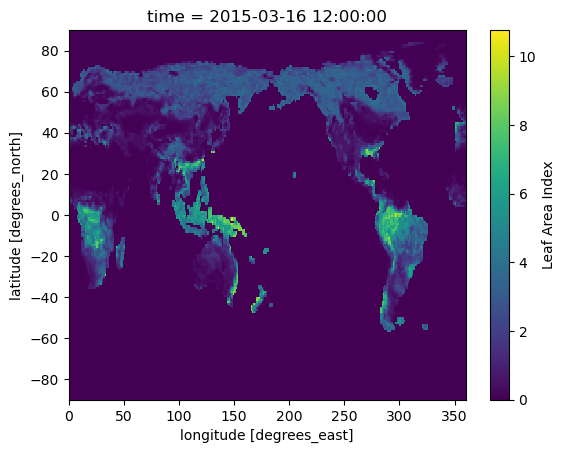

In [97]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[7]].isel(time=2).plot()

### 2. Create consistent time coordinates

In [98]:
# =========== Create consistent time coordinate ==========
# Define reference dataset with desired time coordinate and set variables as some variables seem to have different time coordinates even from the same model
file = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/pr/NorESM2-MM.nc'
file_path = os.path.join(BASE_DIR, file)
ref_ds = xr.open_dataset(file_path)

In [99]:
ref_ds

<xarray.Dataset>
Dimensions:  (time: 1032, lat: 192, lon: 288)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/62)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP AerChemMIP
    branch_method:                    Hybrid-restart from year 2015-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            60225.0
    ...                               ...
    intake_esm_attrs:frequency:       mon
    intake_esm_attrs:time_reduction:   mean
    intake_esm_attrs:realm:           atmos
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           ScenarioMIP.NorESM2-MM.ssp370.Amon.gn
    log:                              Dropped: dcpp_init_year. // Dropped: ti...

In [100]:
# Apply time coordinate on dictionary
ds_dict = consis_time(ds_dict[experiments[0]], ref_ds)

Time variable is already in the requested format


In [85]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[models[12]][variables[1]].isel(time=0).plot()

['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'TaiESM1']


IndexError: list index out of range

### 3. Save and replace netcdf files

In [101]:
# =========== Store file and remove any former one ==========
# Base directory
data_state = 'processed'
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/


In [102]:
sd.save_files(ds_dict, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tas/GFDL-ESM4.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tas/GFDL-ESM4.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/ps/GFDL-ESM4.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/GFDL-ESM4.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/pr/GFDL-ESM4.nc
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/huss/GFDL-ESM4.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/GFDL-ESM4.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/evspsbl/GFDL-ESM4.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/ssp370/month/tran/GFDL-ESM4.nc removed
File saved at: /work/ch0636/g300115/phd_project